# Diffraction for Circular Aperture

In [1]:
#Enable matplotlib and pylab functions to work directly in this notebook
%matplotlib inline
%pylab inline

#Refreshes changes in libraries to be reloaded when they are re-imported
%load_ext autoreload
%autoreload 2

#Import useful modules
import matplotlib
import numpy as np
import time
import os
#Add library path of this repository
sys.path.append(os.path.realpath('../lib'))

#from scipy import ndimage

#Set plotting defaults in notebook
from matplotlib import rcParams
rcParams["font.size"] = "15"

Populating the interactive namespace from numpy and matplotlib


Then define the parameters for the diffraction experiment. All the symbols have their usual meaning (refer to chapter 4 section 4.4.2). 

In [108]:
class diffractor(object):
    def __init__(self, waveLen, det_pix_size, N_pix=256):
        self.waveLen = waveLen
        self.k = 2.*np.pi/waveLen

        # since we fix the pixel size and number of pixels at the detector plane (i.e. xy plane),
        self.N_pix = N_pix                          # number of detector pixels
        self.det_pix_size = det_pix_size            # pixel size at the detector
        self.det_len = det_pix_size*self.N_pix      # detector plane size
        (self.det_x, self.det_y) = self.make2Dplane(self.det_len, self.N_pix)

        self.obj = None
        self.obj_pix = None
        self.xi = None
        self.eta = None
        self.res = None
        self.z = None
        
    def compute_resolution(self, z):
        return self.waveLen*z / (self.det_pix_size*self.N_pix)

    def compute_Fresnel_criterion(self, z):
        pass
        
    def compute_Fraunhofer_criterion(self, z):
        pass

    def make2Dplane(self, Lx, N):
        (x,y) = np.mgrid[-Lx/2:Lx/2:N*1j,-Lx/2:Lx/2:N*1j]
        return (x,y)

    def setup_detector_distance(self, z):
        # once the detector size and its pixel size are fixed it relates to the illumination plane by the Fourier Transform
        # See equation 4-17 (Goodman, chapter4)
        self.z   = z
        self.res = self.compute_resolution(z)
        # compute if we are in the Fresnel or Fraunhofer limit
    
    def make_circ_aperture(self, aperture_rad):
        if self.z is None:
            print("Please setup detector distance")
        else: 
            max_aperture_radius = 0.5*self.res*self.N_pix
            if aperture_rad >= max_aperture_radius:
                print("Aperture radius larger than max: %e"%(max_aperture_radius))
                print("Will use max aperture radius instead")
                curr_aperture_rad = max_aperture_radius
            elif aperture_rad < self.res:
                print("Aperture radius smaller than pixel res: %e"%(self.res))
                print("Will use pixel size as radius instead")
                curr_aperture_rad = self.res
            else:
                curr_aperture_rad = aperture_rad
            (self.xi, self.eta) = self.make2Dplane(2*max_aperture_radius, self.N_pix)
            self.obj = np.sqrt(self.xi*self.xi + self.eta*self.eta) < curr_aperture_rad
    
    def make_square_aperture(self, aperture_rad):
        if self.z is None:
            print("Please setup detector distance")
        else: 
            max_aperture_radius = 0.5*self.res*self.N_pix
            if aperture_rad >= max_aperture_radius:
                print("Aperture radius larger than max: %e"%(max_aperture_radius))
                print("Will use max aperture radius instead")
                curr_aperture_rad = max_aperture_radius
            elif aperture_rad < self.res:
                print("Aperture radius smaller than pixel res: %e"%(self.res))
                print("Will use pixel size as radius instead")
                curr_aperture_rad = self.res
            else:
                curr_aperture_rad = aperture_rad
            (self.xi, self.eta) = self.make2Dplane(2*max_aperture_radius, self.N_pix)
            self.obj = (np.abs(self.xi) < curr_aperture_rad)&(np.abs(self.eta) < curr_aperture_rad)

    
    def Fresnel(self):
        if self.z is None:
            print("Please setup detector distance")
        else:
            quad_phase     = np.exp(1j*self.k*(self.xi*self.xi + self.eta*self.eta)/(2.*self.z))
            overall_phase  = np.exp(1j*self.k*(self.det_x*self.det_x + self.det_y*self.det_y)/(2*self.z)) 
            fall_off       = np.exp(1j*self.k*self.z) / (1j*self.waveLen*self.z)
            U = overall_phase * fall_off * np.fft.fftshift(np.fft.fft2(quad_phase*self.obj))
            I = abs(U)**2
            return I

    def Fraunhofer(self):
        if self.z is None:
            print("Please setup detector distance")
        else:
            fall_off = np.exp(1j*self.k*self.z) / (1j*self.waveLen*self.z)
            U = fall_off * np.fft.fftshift(np.fft.fft2(self.obj))
            I = abs(U)**2
            return I
    

In [139]:
waveLen = 500E-9
r = 5.*waveLen
z = 3000.*waveLen
pixelSize = 6E-6

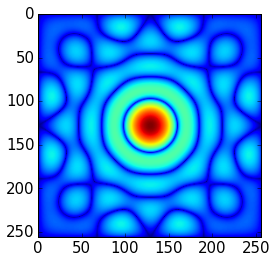

In [141]:
diffObj = diffractor(waveLen, pixelSize)
diffObj.setup_detector_distance(z)
diffObj.make_circ_aperture(r)
#diffObj.make_square_aperture(r)
imshow(np.abs(diffObj.Fraunhofer())**0.2)